<a href="https://colab.research.google.com/github/Monika1945/Histopathological-Image-Based-Cancer-Detection./blob/main/MINI_PROJECT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**used to mount the drive**


In [ ]:
pip install kaggle

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d xilezhu/lc25000

Dataset URL: https://www.kaggle.com/datasets/xilezhu/lc25000
License(s): unknown
 98% 1.73G/1.76G [00:08<00:00, 240MB/s]
100% 1.76G/1.76G [00:09<00:00, 209MB/s]


In [ ]:
!unzip lc25000.zip -d lc25000

Streaming output truncated to the last 5000 lines.
  inflating: lc25000/LC25000/lung_split/val/colon_aca/colonca10.jpeg  
  inflating: lc25000/LC25000/lung_split/val/colon_aca/colonca1008.jpeg  
  inflating: lc25000/LC25000/lung_split/val/colon_aca/colonca1010.jpeg  
  inflating: lc25000/LC25000/lung_split/val/colon_aca/colonca1020.jpeg  
  inflating: lc25000/LC25000/lung_split/val/colon_aca/colonca1024.jpeg  
  inflating: lc25000/LC25000/lung_split/val/colon_aca/colonca1032.jpeg  
  inflating: lc25000/LC25000/lung_split/val/colon_aca/colonca1035.jpeg  
  inflating: lc25000/LC25000/lung_split/val/colon_aca/colonca1045.jpeg  
  inflating: lc25000/LC25000/lung_split/val/colon_aca/colonca1046.jpeg  
  inflating: lc25000/LC25000/lung_split/val/colon_aca/colonca1051.jpeg  
  inflating: lc25000/LC25000/lung_split/val/colon_aca/colonca1052.jpeg  
  inflating: lc25000/LC25000/lung_split/val/colon_aca/colonca1053.jpeg  
  inflating: lc25000/LC25000/lung_split/val/colon_aca/colonca1056.jpeg  
  

**used to unzip the image**

In [ ]:
import os
import cv2
import pandas as pd
from tqdm import tqdm

# Set the base path to your dataset
base_path = '/content/lc25000/LC25000/lung_split'

# Define subfolders for each class
class_folders = {
    'lung_n': ['train/lung_n', 'val/lung_n'],
    'lung_aca': ['train/lung_aca', 'val/lung_aca']
}

# Labels
label_map = {
    'lung_n': 0,
    'lung_aca': 1
}

# Initialize data storage
data = []
labels = []

# Loop through each class
for class_name, folders in class_folders.items():
    count = 0
    max_images = 5000

    print(f"\n📁 Processing {class_name}...")

    for folder in folders:
        folder_path = os.path.join(base_path, folder)

        if not os.path.exists(folder_path):
            print(f"❌ Folder not found: {folder_path}")
            continue

        for filename in tqdm(os.listdir(folder_path)):
            if filename.lower().endswith(('.jpg', '.jpeg', '.png')):
                img_path = os.path.join(folder_path, filename)

                # Read image
                img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)

                # Skip unreadable images
                if img is None:
                    print(f"⚠ Couldn't read image: {img_path}")
                    continue

                # Resize to fixed size
                img = cv2.resize(img, (64, 64))

                # Flatten image to 1D vector
                img_flat = img.flatten()

                # Sanity check
                if len(img_flat) != 64 * 64:
                    print(f"⚠ Invalid image shape at: {img_path}")
                    continue

                # Append to dataset
                data.append(img_flat)
                labels.append(label_map[class_name])
                count += 1

                if count >= max_images:
                    break
        if count >= max_images:
            break

print(f"\n✅ Total samples collected: {len(data)}")

# Final check before creating DataFrame
if data:
    df = pd.DataFrame(data)
    df['label'] = labels
    df.to_csv('merged_lung_dataset_grayscale.csv', index=False)
    print("✅ CSV saved as 'merged_lung_dataset_grayscale.csv'")
else:
    print("❌ No data was collected. Please check image paths and formats.")


📁 Processing lung_n...


100%|█████████▉| 999/1000 [00:01<00:00, 654.65it/s]



📁 Processing lung_aca...


100%|█████████▉| 999/1000 [00:01<00:00, 562.46it/s]



✅ Total samples collected: 10000
✅ CSV saved as 'merged_lung_dataset_grayscale.csv'


**merged dataset**(dataset)



In [ ]:
from google.colab import files
files.download('merged_lung_dataset_grayscale.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
# Install the missing library
!pip install scikit-fuzzy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 920.8/920.8 kB 14.7 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import skfuzzy as fuzz
from sklearn.preprocessing import MinMaxScaler

# Load dataset
df = pd.read_csv('/content/merged_lung_dataset_grayscale.csv')

# Split features and labels (assuming last column is label)
pixels = df.iloc[:, :-1].values  # all columns except last
labels = df.iloc[:, -1].values   # last column as label

# Normalize pixel data to [0, 1] range
scaler = MinMaxScaler()
pixels_normalized = scaler.fit_transform(pixels)

# Adaptive Fuzzy Filter Function
def adaptive_fuzzy_filter(image_flat):
    # Assume input is 1D flattened image, reshape to square if needed
    img_size = int(np.sqrt(len(image_flat)))
    image = image_flat.reshape((img_size, img_size))

    # Create fuzzy membership functions for low, medium, high intensities
    x = np.linspace(0, 1, 100)
    low = fuzz.trimf(x, [0, 0, 0.5])
    med = fuzz.trimf(x, [0.25, 0.5, 0.75])
    high = fuzz.trimf(x, [0.5, 1, 1])

    filtered_image = np.zeros_like(image)

    # Apply fuzzy logic to each pixel
    for i in range(img_size):
        for j in range(img_size):
            val = image[i, j]
            low_val = fuzz.interp_membership(x, low, val)
            med_val = fuzz.interp_membership(x, med, val)
            high_val = fuzz.interp_membership(x, high, val)

            # Adaptive smoothing rule:
            # If medium dominates, preserve value; if high or low, smooth using neighborhood
            if med_val > max(low_val, high_val):
                filtered_image[i, j] = val
            else:
                # Simple 3x3 neighborhood averaging for smoothing
                neighbors = image[max(0, i-1):i+2, max(0, j-1):j+2]
                filtered_image[i, j] = np.mean(neighbors)

    return filtered_image.flatten()

# Apply adaptive fuzzy filtering to all images
filtered_pixels = np.array([adaptive_fuzzy_filter(img) for img in pixels_normalized])

# Combine with labels again
filtered_df = pd.DataFrame(filtered_pixels)
filtered_df['label'] = labels

# Save to new CSV file
filtered_df.to_csv('lung_dataset_fuzzy_filtered.csv', index=False)

print("Filtered dataset saved as 'lung_dataset_fuzzy_filtered.csv'")

FileNotFoundError: [Errno 2] No such file or directory: '/content/merged_lung_dataset_grayscale.csv'

**fuzzy filter**

In [ ]:
from google.colab import files
files.download('lung_dataset_fuzzy_filtered.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
import numpy as np
from skimage.feature import hog
from skimage import exposure

# Load fuzzy-filtered dataset
df = pd.read_csv('lung_dataset_fuzzy_filtered.csv')

# Split features and labels
pixels = df.iloc[:, :-1].values  # all columns except the last
labels = df.iloc[:, -1].values   # last column is label

# Determine image size (assuming square images)
img_size = int(np.sqrt(pixels.shape[1]))

# HOG parameters (you can tune these for better results)
hog_features = []
for img_flat in pixels:
    img = img_flat.reshape((img_size, img_size))

    features = hog(img,
                   orientations=9,
                   pixels_per_cell=(8, 8),
                   cells_per_block=(2, 2),
                   block_norm='L2-Hys',
                   visualize=False,
                   feature_vector=True)

    hog_features.append(features)

# Convert to DataFrame
hog_df = pd.DataFrame(hog_features)
hog_df['label'] = labels

# Save HOG features to CSV
hog_df.to_csv('lung_dataset_HOG_features.csv', index=False)

print("HOG features saved to 'lung_dataset_HOG_features.csv'")


HOG features saved to 'lung_dataset_HOG_features.csv'


**hog fillter**


In [ ]:
from google.colab import files
files.download('lung_dataset_HOG_features.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score

# Load dataset
df = pd.read_csv('lung_dataset_HOG_features.csv')

# Separate features and label
X = df.drop('label', axis=1).values
y = df['label'].values

# Index-based splitting
n = len(X)
train_end = int(0.8 * n)
val_end = int(0.9 * n)

X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val = X[train_end:val_end], y[train_end:val_end]
X_test, y_test = X[val_end:], y[val_end:]

# Define classifiers
classifiers = {
    "SVM": SVC(),
    "GradientBoost": GradientBoostingClassifier(),
    "KNN": KNeighborsClassifier(),
    "ExtraTrees": ExtraTreesClassifier(),
    "MLP": MLPClassifier(max_iter=300)
}

# Train and evaluate
results = {}
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy

# Print results
for name, acc in results.items():
    print(f"{name}: {acc:.4f}")


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/usr/local/lib/python3.11/dist-packages/IPython/core/interactiveshell.py", line 3553, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-1-3165391715>", line 36, in <cell line: 0>
    clf.fit(X_train, y_train)
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389, in wrapper
    return fit_method(estimator, *args, **kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_gb.py", line 787, in fit
    n_stages = self._fit_stages(
               ^^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_gb.py", line 883, in _fit_stages
    raw_predictions = self._fit_stage(
                      ^^^^^^^^^^^^^^^^
  File "/usr/local/lib/python3.11/dist-packages/sklearn/ensemble/_gb.py", line 489, in _fit_stage
    tree.fit(
  File "/usr/local/lib/python3.11/dist-packages/sklearn/base.py", line 1389

TypeError: object of type 'NoneType' has no len()

In [ ]:
pip install catboost


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier  # <-- Add CatBoost

# Load dataset
df = pd.read_csv('lung_dataset_HOG_features.csv')

# Separate features and label
X = df.drop('label', axis=1).values
y = df['label'].values

# Index-based splitting
n = len(X)
train_end = int(0.8 * n)
val_end = int(0.9 * n)

X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val = X[train_end:val_end], y[train_end:val_end]
X_test, y_test = X[val_end:], y[val_end:]

# Define classifiers
classifiers = {
    "SVM": SVC(),
    "GradientBoost": GradientBoostingClassifier(),
    "KNN": KNeighborsClassifier(),
    "ExtraTrees": ExtraTreesClassifier(),
    "MLP": MLPClassifier(max_iter=300),
    "CatBoost": CatBoostClassifier(verbose=0)  # <-- Added CatBoost
}

# Train and evaluate
results = {}
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy

# Print results
for name, acc in results.items():
    print(f"{name}: {acc:.4f}")


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


SVM: 0.7890
GradientBoost: 0.7590
KNN: 0.9980
ExtraTrees: 0.6730
MLP: 0.7330
CatBoost: 0.7980


**accuracy for hog**

In [ ]:
import pandas as pd
import numpy as np
from skimage.feature import local_binary_pattern

# Parameters for LBP
radius = 1
n_points = 8 * radius
method = 'uniform'  # You can also try 'default' or 'ror'

# Load fuzzy-filtered dataset
df = pd.read_csv('lung_dataset_fuzzy_filtered.csv')

# Split features and labels
pixels = df.iloc[:, :-1].values
labels = df.iloc[:, -1].values

# Determine image size
img_size = int(np.sqrt(pixels.shape[1]))

# Extract LBP features
lbp_features = []
for img_flat in pixels:
    img = img_flat.reshape((img_size, img_size))

    # Apply LBP
    lbp = local_binary_pattern(img, n_points, radius, method)

    # Build histogram of LBP patterns (normalized)
    n_bins = int(lbp.max() + 1)
    hist, _ = np.histogram(lbp.ravel(), bins=n_bins, range=(0, n_bins), density=True)

    lbp_features.append(hist)

# Convert to DataFrame
lbp_df = pd.DataFrame(lbp_features)
lbp_df['label'] = labels

# Save LBP features to CSV
lbp_df.to_csv('lung_dataset_LBP_features.csv', index=False)

print("LBP features saved to 'lung_dataset_LBP_features.csv'")


/usr/local/lib/python3.11/dist-packages/skimage/feature/texture.py:385: UserWarning: Applying `local_binary_pattern` to floating-point images may give unexpected results when small numerical differences between adjacent pixels are present. It is recommended to use this function with images of integer dtype.
  warnings.warn(


LBP features saved to 'lung_dataset_LBP_features.csv'


**lbp filter**

In [ ]:
from google.colab import files
files.download('lung_dataset_LBP_features.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier  # <-- Add CatBoost

# Load dataset
df = pd.read_csv('lung_dataset_LBP_features.csv')

# Separate features and label
X = df.drop('label', axis=1).values
y = df['label'].values

# Index-based splitting
n = len(X)
train_end = int(0.8 * n)
val_end = int(0.9 * n)

X_train, y_train = X[:train_end], y[:train_end]
X_val, y_val = X[train_end:val_end], y[train_end:val_end]
X_test, y_test = X[val_end:], y[val_end:]

# Define classifiers
classifiers = {
    "SVM": SVC(),
    "GradientBoost": GradientBoostingClassifier(),
    "KNN": KNeighborsClassifier(),
    "ExtraTrees": ExtraTreesClassifier(),
    "MLP": MLPClassifier(max_iter=300),
    "CatBoost": CatBoostClassifier(verbose=0)  # <-- Added CatBoost
}

# Train and evaluate
results = {}
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy

# Print results
for name, acc in results.items():
    print(f"{name}: {acc:.4f}")

SVM: 0.8250
GradientBoost: 0.8520
KNN: 0.8360
ExtraTrees: 0.8590
MLP: 0.8340
CatBoost: 0.8670


**accuracy for lbp**


===== CatBoost =====
Accuracy: 0.9230
Confusion Matrix:
[[945  55]
 [ 99 901]]


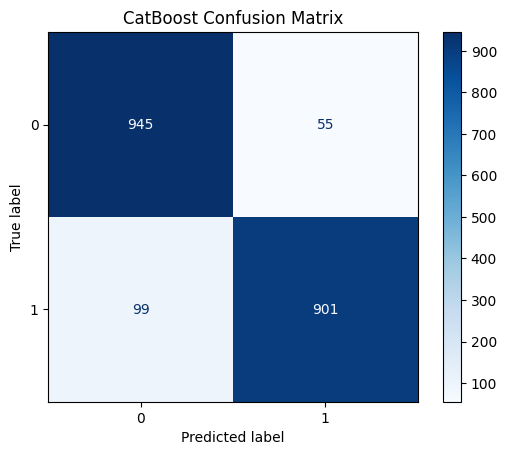


===== ExtraTrees =====
Accuracy: 0.9215
Confusion Matrix:
[[944  56]
 [101 899]]


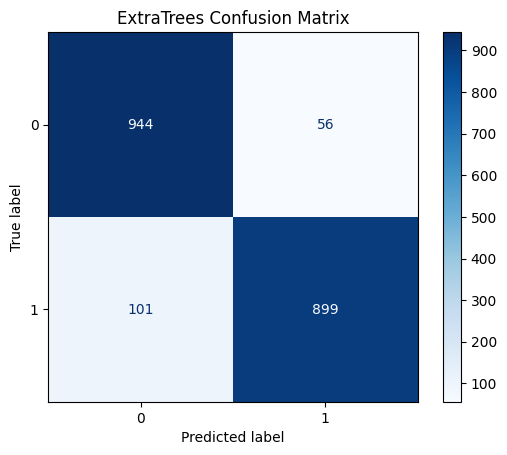


===== SVM =====
Accuracy: 0.9125
Confusion Matrix:
[[943  57]
 [118 882]]


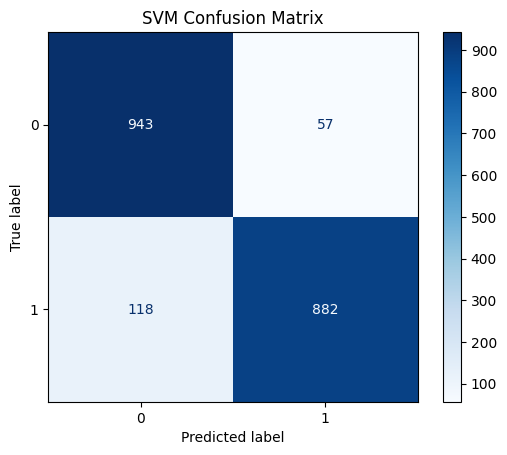


===== MLP =====


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


Accuracy: 0.9120
Confusion Matrix:
[[925  75]
 [101 899]]


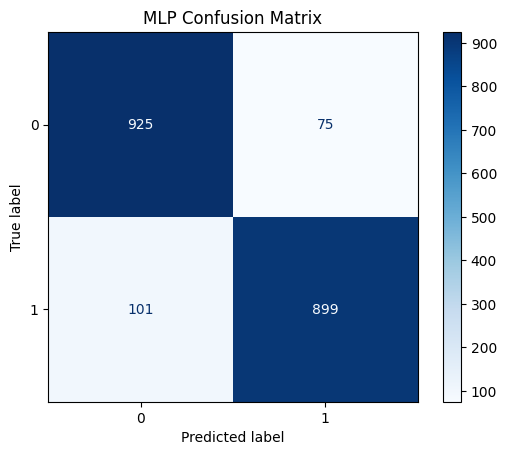


===== KNN =====
Accuracy: 0.8980
Confusion Matrix:
[[920  80]
 [124 876]]


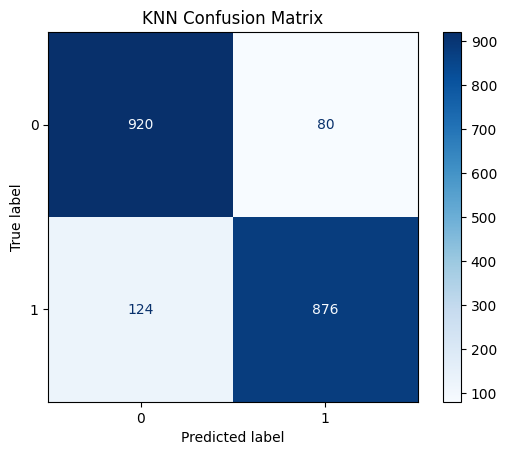


===== GradientBoosting =====
Accuracy: 0.9090
Confusion Matrix:
[[929  71]
 [111 889]]


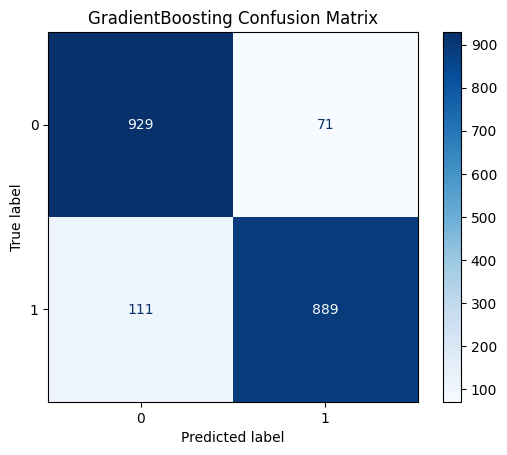

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

# Load data
csv_path = '/content/lung_dataset_LBP_features.csv'
df = pd.read_csv(csv_path)

# Separate features and labels
X = df.drop(columns=['label']).values
y = df['label'].values

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # Example: lung_n -> 0, lung_aca -> 1

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Scale features for certain classifiers
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize classifiers
classifiers = {
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "ExtraTrees": ExtraTreesClassifier(random_state=42),
    "SVM": SVC(kernel='rbf', random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "GradientBoosting": GradientBoostingClassifier(random_state=42)
}

# Train, predict, and display confusion matrix for each
for name, clf in classifiers.items():
    print(f"\n===== {name} =====")
    if name in ['SVM', 'MLP', 'KNN', 'GradientBoosting']:
        clf.fit(X_train_scaled, y_train)
        y_pred = clf.predict(X_test_scaled)
    else:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # Plot Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.show()


===== CatBoost =====
Accuracy: 0.9230
Confusion Matrix:
[[945  55]
 [ 99 901]]
TN: 945  TP: 901  FP: 55  FN: 99


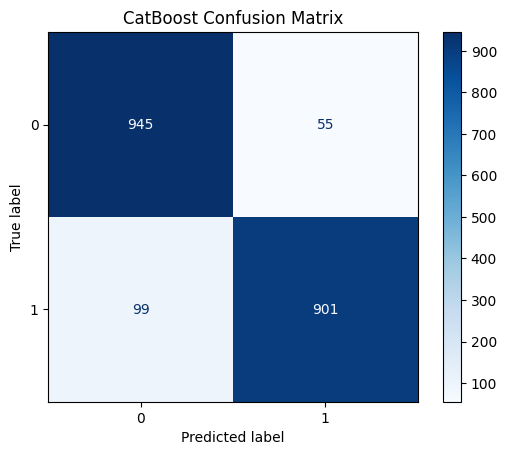


===== ExtraTrees =====
Accuracy: 0.9215
Confusion Matrix:
[[944  56]
 [101 899]]
TN: 944  TP: 899  FP: 56  FN: 101


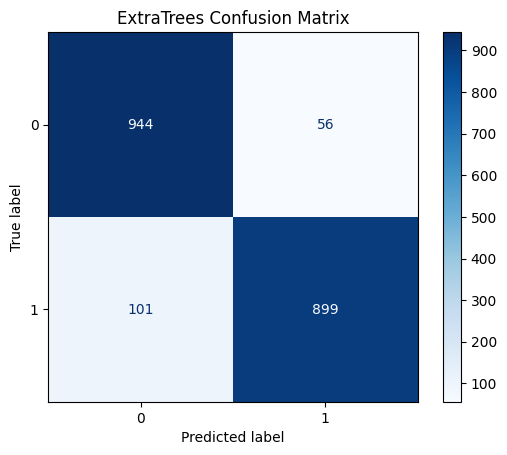


===== SVM =====
Accuracy: 0.9125
Confusion Matrix:
[[943  57]
 [118 882]]
TN: 943  TP: 882  FP: 57  FN: 118


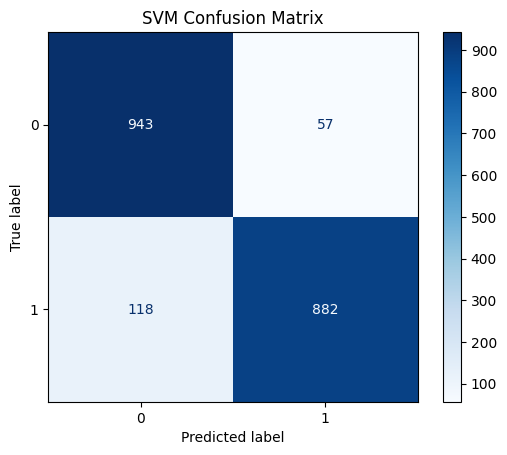


===== MLP =====
Accuracy: 0.9120
Confusion Matrix:
[[925  75]
 [101 899]]
TN: 925  TP: 899  FP: 75  FN: 101


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


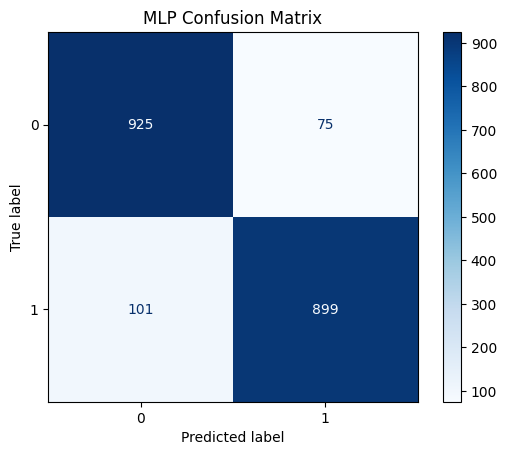


===== KNN =====
Accuracy: 0.8980
Confusion Matrix:
[[920  80]
 [124 876]]
TN: 920  TP: 876  FP: 80  FN: 124


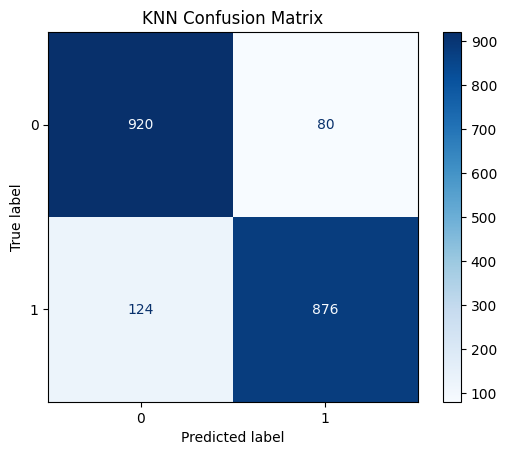


===== GradientBoosting =====
Accuracy: 0.9090
Confusion Matrix:
[[929  71]
 [111 889]]
TN: 929  TP: 889  FP: 71  FN: 111


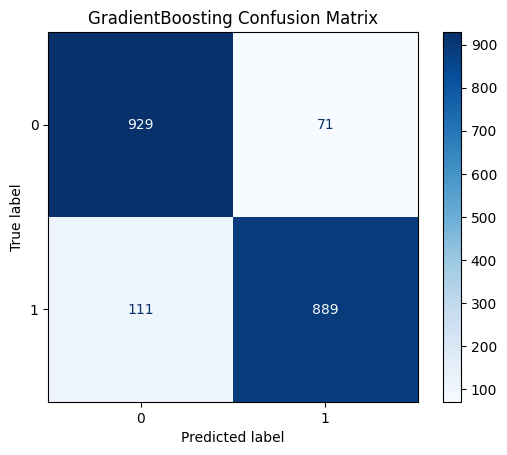

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

# Load data
csv_path = '/content/lung_dataset_LBP_features.csv'
df = pd.read_csv(csv_path)

# Separate features and labels
X = df.drop(columns=['label']).values
y = df['label'].values

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # Example: lung_n -> 0, lung_aca -> 1

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Scale features for certain classifiers
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize classifiers
classifiers = {
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "ExtraTrees": ExtraTreesClassifier(random_state=42),
    "SVM": SVC(kernel='rbf', random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "GradientBoosting": GradientBoostingClassifier(random_state=42)
}

# Train, predict, and display confusion matrix for each
for name, clf in classifiers.items():
    print(f"\n===== {name} =====")
    if name in ['SVM', 'MLP', 'KNN', 'GradientBoosting']:
        clf.fit(X_train_scaled, y_train)
        y_pred = clf.predict(X_test_scaled)
    else:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)
    TN, FP, FN, TP = cm.ravel()
    print(f"TN: {TN}  TP: {TP}  FP: {FP}  FN: {FN}")
    # Plot Confusion Matrix
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=le.classes_)
    disp.plot(cmap='Blues')
    plt.title(f'{name} Confusion Matrix')
    plt.show()


===== CatBoost =====
Accuracy: 0.9230
Confusion Matrix:
[[945  55]
 [ 99 901]]


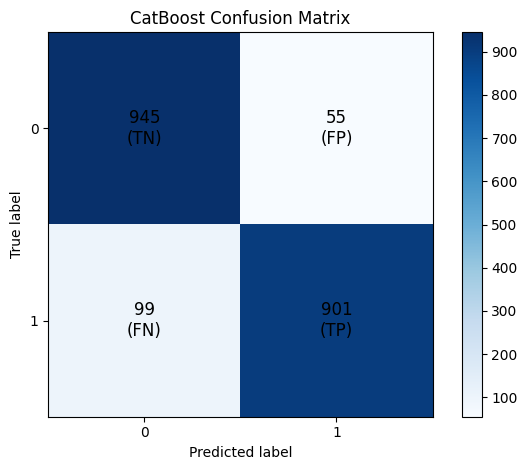


===== ExtraTrees =====
Accuracy: 0.9215
Confusion Matrix:
[[944  56]
 [101 899]]


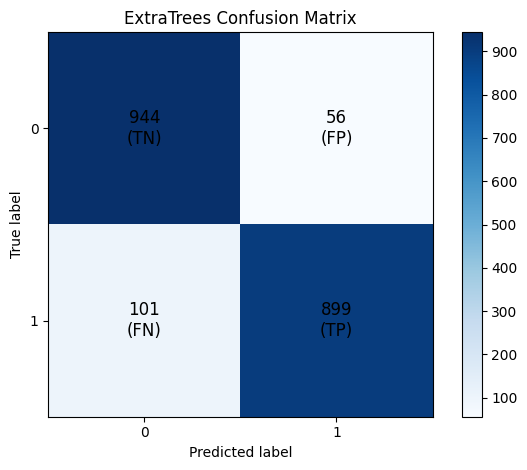


===== SVM =====
Accuracy: 0.9125
Confusion Matrix:
[[943  57]
 [118 882]]


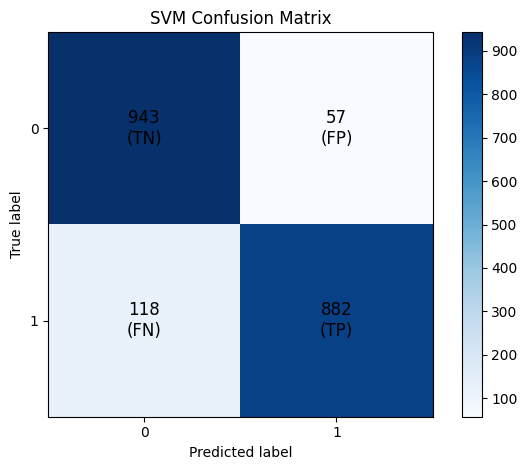


===== MLP =====
Accuracy: 0.9120
Confusion Matrix:
[[925  75]
 [101 899]]


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (300) reached and the optimization hasn't converged yet.
  warnings.warn(


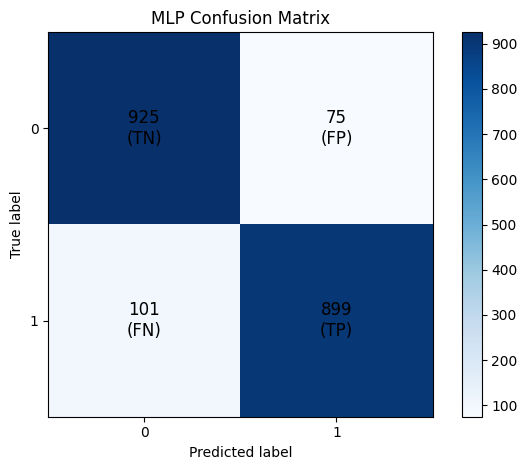


===== KNN =====
Accuracy: 0.8980
Confusion Matrix:
[[920  80]
 [124 876]]


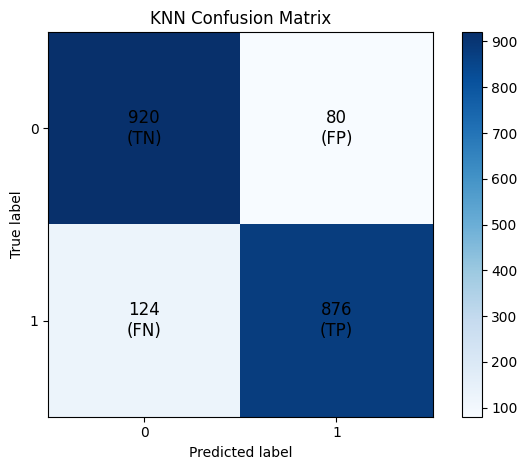


===== GradientBoosting =====
Accuracy: 0.9090
Confusion Matrix:
[[929  71]
 [111 889]]


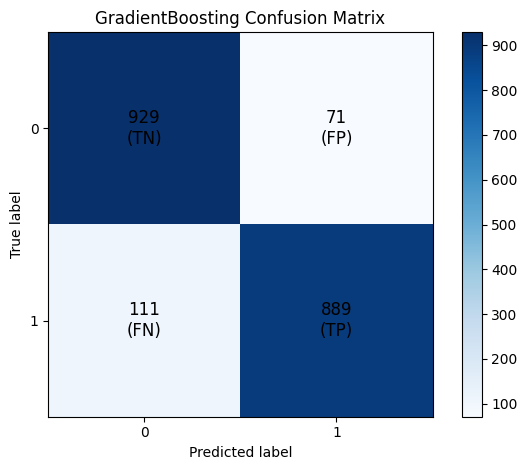

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score, confusion_matrix
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import numpy as np

# Load data
csv_path = '/content/lung_dataset_LBP_features.csv'
df = pd.read_csv(csv_path)

# Separate features and labels
X = df.drop(columns=['label']).values
y = df['label'].values

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Scale features for certain classifiers
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize classifiers
classifiers = {
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "ExtraTrees": ExtraTreesClassifier(random_state=42),
    "SVM": SVC(kernel='rbf', random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "GradientBoosting": GradientBoostingClassifier(random_state=42)
}

# Function to plot confusion matrix with TP/TN/FP/FN labels
def plot_confusion_matrix_with_labels(cm, labels, title='Confusion Matrix'):
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)

    # Title and colorbar
    ax.set_title(title)
    plt.colorbar(im)

    # Axis labels
    tick_marks = np.arange(len(labels))
    ax.set_xticks(tick_marks)
    ax.set_yticks(tick_marks)
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    ax.set_xlabel('Predicted label')
    ax.set_ylabel('True label')

    # Only works for binary classification
    if len(labels) == 2:
        TP = cm[1,1]
        FN = cm[1,0]
        FP = cm[0,1]
        TN = cm[0,0]

        # Write text in each cell
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                text = f'{cm[i,j]}'
                if i==0 and j==0:
                    text += '\n(TN)'
                elif i==0 and j==1:
                    text += '\n(FP)'
                elif i==1 and j==0:
                    text += '\n(FN)'
                elif i==1 and j==1:
                    text += '\n(TP)'

                ax.text(j, i, text, ha='center', va='center', color='black', fontsize=12)
    else:
        # For multi-class, just print the number
        for i in range(cm.shape[0]):
            for j in range(cm.shape[1]):
                ax.text(j, i, f'{cm[i,j]}', ha='center', va='center', color='black', fontsize=12)

    plt.tight_layout()
    plt.show()

# Train, predict, and display confusion matrix for each classifier
for name, clf in classifiers.items():
    print(f"\n===== {name} =====")
    if name in ['SVM', 'MLP', 'KNN', 'GradientBoosting']:
        clf.fit(X_train_scaled, y_train)
        y_pred = clf.predict(X_test_scaled)
    else:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

    # Accuracy
    acc = accuracy_score(y_test, y_pred)
    print(f"Accuracy: {acc:.4f}")

    # Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)

    # Plot Confusion Matrix with labels
    plot_confusion_matrix_with_labels(cm, le.classes_, title=f'{name} Confusion Matrix')


In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
import numpy as np

# Load dataset
df = pd.read_csv('/content/lung_dataset_HOG_features.csv')

# Separate features and label
X = df.drop('label', axis=1).values
y = df['label'].values

# Indices for each class
normal_indices = np.where(y == 0)[0]  # Assuming 0 = Normal
cancer_indices = np.where(y == 1)[0]  # Assuming 1 = Cancer

# Shuffle to avoid ordering bias
np.random.seed(42)
np.random.shuffle(normal_indices)
np.random.shuffle(cancer_indices)

# Split each class into train/val/test (80/10/10)
def split_indices(indices):
    n = len(indices)
    train_end = int(0.8 * n)
    val_end = int(0.9 * n)
    return indices[:train_end], indices[train_end:val_end], indices[val_end:]

normal_train, normal_val, normal_test = split_indices(normal_indices)
cancer_train, cancer_val, cancer_test = split_indices(cancer_indices)

# Combine indices
train_indices = np.concatenate([normal_train, cancer_train])
val_indices = np.concatenate([normal_val, cancer_val])
test_indices = np.concatenate([normal_test, cancer_test])

# Shuffle the final splits
np.random.shuffle(train_indices)
np.random.shuffle(val_indices)
np.random.shuffle(test_indices)

# Split the data
X_train, y_train = X[train_indices], y[train_indices]
X_val, y_val = X[val_indices], y[val_indices]
X_test, y_test = X[test_indices], y[test_indices]

# Define classifiers
classifiers = {
    "SVM": SVC(),
    "GradientBoost": GradientBoostingClassifier(),
    "KNN": KNeighborsClassifier(),
    "ExtraTrees": ExtraTreesClassifier(),
    "MLP": MLPClassifier(max_iter=300),
    "CatBoost": CatBoostClassifier(verbose=0)
}

# Train and evaluate
results = {}
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy

# Print results
for name, acc in results.items():
    print(f"{name}: {acc:.4f}")

SVM: 0.9012
GradientBoost: 0.8663
KNN: 0.4869
ExtraTrees: 0.8430
MLP: 0.8837
CatBoost: 0.9026


**accracy for hog (random.seed)**

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 8.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
import numpy as np

# Load dataset
df = pd.read_csv('/content/lung_dataset_HOG_features.csv')

# Separate features and label
X = df.drop('label', axis=1).values
y = df['label'].values

# Indices for each class
normal_indices = np.where(y == 0)[0]  # Assuming 0 = Normal
cancer_indices = np.where(y == 1)[0]  # Assuming 1 = Cancer

# Shuffle to avoid ordering bias
np.random.seed(42)
np.random.shuffle(normal_indices)
np.random.shuffle(cancer_indices)

# Split each class into train/val/test (80/10/10)
def split_indices(indices):
    n = len(indices)
    train_end = int(0.8 * n)
    val_end = int(0.9 * n)
    return indices[:train_end], indices[train_end:val_end], indices[val_end:]

normal_train, normal_val, normal_test = split_indices(normal_indices)
cancer_train, cancer_val, cancer_test = split_indices(cancer_indices)

# Combine indices
train_indices = np.concatenate([normal_train, cancer_train])
val_indices = np.concatenate([normal_val, cancer_val])
test_indices = np.concatenate([normal_test, cancer_test])

# Shuffle the final splits
np.random.shuffle(train_indices)
np.random.shuffle(val_indices)
np.random.shuffle(test_indices)

# Split the data
X_train, y_train = X[train_indices], y[train_indices]
X_val, y_val = X[val_indices], y[val_indices]
X_test, y_test = X[test_indices], y[test_indices]

# Define classifiers
classifiers = {
    "SVM": SVC(),
    "GradientBoost": GradientBoostingClassifier(),
    "KNN": KNeighborsClassifier(),
    "ExtraTrees": ExtraTreesClassifier(),
    "MLP": MLPClassifier(max_iter=300),
    "CatBoost": CatBoostClassifier(verbose=0)
}

# Train and evaluate
results = {}
for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    results[name] = accuracy

# Print results
for name, acc in results.items():
    print(f"{name}: {acc:.4f}")

SVM: 0.8850
GradientBoost: 0.8450
KNN: 0.6080
ExtraTrees: 0.8780
MLP: 0.8660
CatBoost: 0.8850


**hog filter accuracy**

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Fitness function: returns classification accuracy using selected features
def fitness_function(position, X, y, threshold=0.5):
    binary_mask = position > threshold
    if np.sum(binary_mask) == 0:
        return 0
    X_selected = X[:, binary_mask]
    clf = RandomForestClassifier(n_estimators=50)
    score = cross_val_score(clf, X_selected, y, cv=5, scoring='accuracy')
    return score.mean()

# Reptile Search Algorithm
def reptile_search_algorithm(X, y, fitness_function, population_size=20, max_iter=50, threshold=0.5):
    num_features = X.shape[1]
    population = np.random.rand(population_size, num_features)
    fitness_scores = np.array([fitness_function(ind, X, y, threshold) for ind in population])

    best_idx = np.argmax(fitness_scores)
    best_position = population[best_idx].copy()
    best_score = fitness_scores[best_idx]

    for t in range(max_iter):
        for i in range(population_size):
            r1, r2 = np.random.rand(), np.random.rand()
            if t < max_iter / 2:
                new_pos = population[i] + r1 * (best_position - population[i]) + r2 * (np.random.rand(num_features) - 0.5)
            else:
                new_pos = population[i] + r1 * (best_position - population[i]) - r2 * (np.random.rand(num_features) - 0.5)
            new_pos = np.clip(new_pos, 0, 1)

            new_score = fitness_function(new_pos, X, y, threshold)
            if new_score > fitness_scores[i]:
                population[i] = new_pos
                fitness_scores[i] = new_score
                if new_score > best_score:
                    best_position = new_pos.copy()
                    best_score = new_score
        print(f"Iteration {t+1}/{max_iter} — Best Fitness: {best_score:.4f}")

    return best_position > threshold, best_score

# === Load HOG dataset ===
df = pd.read_csv('/content/lung_dataset_HOG_features.csv')
X = df.drop('label', axis=1).values
y = df['label'].values

# Run RSA
selected_features_mask, best_score = reptile_search_algorithm(X, y, fitness_function)

# Save selected features
X_selected = X[:, selected_features_mask]
selected_df = pd.DataFrame(X_selected)
selected_df['label'] = y
selected_df.to_csv('lung_dataset_HOG_RSA_selected.csv', index=False)

print("Selected features saved to 'lung_dataset_HOG_RSA_selected.csv'")

KeyboardInterrupt: 

In [ ]:
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Fitness function: returns classification accuracy using selected features
def fitness_function(position, X, y, threshold=0.5):
    binary_mask = position > threshold
    if np.sum(binary_mask) == 0:
        return 0
    X_selected = X[:, binary_mask]
    clf = RandomForestClassifier(n_estimators=20)
    score = cross_val_score(clf, X_selected, y, cv=5, scoring='accuracy', n_jobs=-1)
    return score.mean()

def reptile_search_algorithm(X, y, fitness_function, population_size=10, max_iter=20, threshold=0.5):
    num_features = X.shape[1]
    population = np.random.rand(population_size, num_features)
    fitness_scores = np.array([fitness_function(ind, X, y, threshold) for ind in population])

    best_idx = np.argmax(fitness_scores)
    best_position = population[best_idx].copy()
    best_score = fitness_scores[best_idx]

    for t in range(max_iter):
        start_time = time.time()

        for i in range(population_size):
            r1, r2 = np.random.rand(), np.random.rand()
            if t < max_iter / 2:
                new_pos = population[i] + r1 * (best_position - population[i]) + r2 * (np.random.rand(num_features) - 0.5)
            else:
                new_pos = population[i] + r1 * (best_position - population[i]) - r2 * (np.random.rand(num_features) - 0.5)

            new_pos = np.clip(new_pos, 0, 1)
            new_score = fitness_function(new_pos, X, y, threshold)

            if new_score > fitness_scores[i]:
                population[i] = new_pos
                fitness_scores[i] = new_score
                if new_score > best_score:
                    best_position = new_pos.copy()
                    best_score = new_score

        elapsed_time = time.time() - start_time
        print(f"Iteration {t+1}/{max_iter} — Best Fitness: {best_score:.4f} — Time: {elapsed_time:.2f}s")

    return best_position > threshold, best_score

# === Load HOG dataset ===
df = pd.read_csv('/content/lung_dataset_HOG_features.csv')
X = df.drop('label', axis=1).values
y = df['label'].values

# Run RSA
selected_features_mask, best_score = reptile_search_algorithm(X, y, fitness_function)

# Save selected features
X_selected = X[:, selected_features_mask]
selected_df = pd.DataFrame(X_selected)
selected_df['label'] = y
selected_df.to_csv('lung_dataset_HOG_RSA_selected.csv', index=False)

print("Selected features saved to 'lung_dataset_HOG_RSA_selected.csv'")


KeyboardInterrupt: 

In [ ]:
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Fitness function: returns classification accuracy using selected features
def fitness_function(position, X, y, threshold=0.5):
    binary_mask = position > threshold
    if np.sum(binary_mask) == 0:
        return 0
    X_selected = X[:, binary_mask]
    clf = RandomForestClassifier(n_estimators=10, random_state=42)  # Fewer trees
    score = cross_val_score(clf, X_selected, y, cv=3, scoring='accuracy', n_jobs=-1)  # Fewer folds
    return score.mean()

# Reptile Search Algorithm (faster version)
def reptile_search_algorithm(X, y, fitness_function, population_size=8, max_iter=15, threshold=0.5):
    num_features = X.shape[1]
    population = np.random.rand(population_size, num_features)
    fitness_scores = np.array([fitness_function(ind, X, y, threshold) for ind in population])

    best_idx = np.argmax(fitness_scores)
    best_position = population[best_idx].copy()
    best_score = fitness_scores[best_idx]
    no_improvement = 0

    for t in range(max_iter):
        start_time = time.time()
        prev_best = best_score

        for i in range(population_size):
            r1, r2 = np.random.rand(), np.random.rand()
            if t < max_iter / 2:
                new_pos = population[i] + r1 * (best_position - population[i]) + r2 * (np.random.rand(num_features) - 0.5)
            else:
                new_pos = population[i] + r1 * (best_position - population[i]) - r2 * (np.random.rand(num_features) - 0.5)

            new_pos = np.clip(new_pos, 0, 1)
            new_score = fitness_function(new_pos, X, y, threshold)

            if new_score > fitness_scores[i]:
                population[i] = new_pos
                fitness_scores[i] = new_score
                if new_score > best_score:
                    best_position = new_pos.copy()
                    best_score = new_score

        # Early stopping check
        if best_score == prev_best:
            no_improvement += 1
        else:
            no_improvement = 0
        if no_improvement >= 5:
            print("Early stopping: no improvement in 5 iterations.")
            break

        elapsed_time = time.time() - start_time
        print(f"Iteration {t+1}/{max_iter} — Best Fitness: {best_score:.4f} — Time: {elapsed_time:.2f}s")

    return best_position > threshold, best_score

# === Load HOG dataset ===
df = pd.read_csv('/content/lung_dataset_HOG_features.csv')

# Optional: Speed test using only part of dataset
# df = df.sample(n=500, random_state=42)  # Uncomment to test faster

X = df.drop('label', axis=1).values
y = df['label'].values

# Run RSA
selected_features_mask, best_score = reptile_search_algorithm(X, y, fitness_function)

# Save selected features
X_selected = X[:, selected_features_mask]
selected_df = pd.DataFrame(X_selected)
selected_df['label'] = y
selected_df.to_csv('lung_dataset_HOG_RSA_selected.csv', index=False)

print("Selected features saved to 'lung_dataset_HOG_RSA_selected.csv'")


Iteration 1/15 — Best Fitness: 0.7865 — Time: 85.32s
Iteration 2/15 — Best Fitness: 0.7865 — Time: 84.11s
Iteration 3/15 — Best Fitness: 0.7867 — Time: 85.69s
Iteration 4/15 — Best Fitness: 0.7867 — Time: 85.95s
Iteration 5/15 — Best Fitness: 0.7867 — Time: 85.34s
Iteration 6/15 — Best Fitness: 0.7867 — Time: 88.29s
Iteration 7/15 — Best Fitness: 0.7867 — Time: 88.29s
Iteration 8/15 — Best Fitness: 0.7875 — Time: 85.85s
Iteration 9/15 — Best Fitness: 0.7875 — Time: 84.36s
Iteration 10/15 — Best Fitness: 0.7875 — Time: 84.03s
Iteration 11/15 — Best Fitness: 0.7875 — Time: 85.90s
Iteration 12/15 — Best Fitness: 0.7875 — Time: 85.40s
Early stopping: no improvement in 5 iterations.
Selected features saved to 'lung_dataset_HOG_RSA_selected.csv'


**RSA for hog**

In [ ]:
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

# Set global random seed for reproducibility
np.random.seed(42)

# Fitness function: returns classification accuracy using selected features
def fitness_function(position, X, y, threshold=0.5):
    binary_mask = position > threshold
    if np.sum(binary_mask) == 0:
        return 0
    X_selected = X[:, binary_mask]
    clf = RandomForestClassifier(n_estimators=10, random_state=42)  # Fewer trees
    score = cross_val_score(clf, X_selected, y, cv=3, scoring='accuracy', n_jobs=-1)
    return score.mean()

# Reptile Search Algorithm (faster version)
def reptile_search_algorithm(X, y, fitness_function, population_size=8, max_iter=15, threshold=0.5):
    num_features = X.shape[1]
    population = np.random.rand(population_size, num_features)  # Seeded above
    fitness_scores = np.array([fitness_function(ind, X, y, threshold) for ind in population])

    best_idx = np.argmax(fitness_scores)
    best_position = population[best_idx].copy()
    best_score = fitness_scores[best_idx]
    no_improvement = 0

    for t in range(max_iter):
        start_time = time.time()
        prev_best = best_score

        for i in range(population_size):
            r1, r2 = np.random.rand(), np.random.rand()
            if t < max_iter / 2:
                new_pos = population[i] + r1 * (best_position - population[i]) + r2 * (np.random.rand(num_features) - 0.5)
            else:
                new_pos = population[i] + r1 * (best_position - population[i]) - r2 * (np.random.rand(num_features) - 0.5)

            new_pos = np.clip(new_pos, 0, 1)
            new_score = fitness_function(new_pos, X, y, threshold)

            if new_score > fitness_scores[i]:
                population[i] = new_pos
                fitness_scores[i] = new_score
                if new_score > best_score:
                    best_position = new_pos.copy()
                    best_score = new_score

        # Early stopping check
        if best_score == prev_best:
            no_improvement += 1
        else:
            no_improvement = 0
        if no_improvement >= 5:
            print("Early stopping: no improvement in 5 iterations.")
            break

        elapsed_time = time.time() - start_time
        print(f"Iteration {t+1}/{max_iter} — Best Fitness: {best_score:.4f} — Time: {elapsed_time:.2f}s")

    return best_position > threshold, best_score

# === Load HOG dataset ===
df = pd.read_csv('/content/lung_dataset_HOG_features.csv')

# Optional: Speed test using only part of dataset
# df = df.sample(n=500, random_state=42)  # Uncomment to test faster

X = df.drop('label', axis=1).values
y = df['label'].values

# Run RSA
selected_features_mask, best_score = reptile_search_algorithm(X, y, fitness_function)

# Save selected features
X_selected = X[:, selected_features_mask]
selected_df = pd.DataFrame(X_selected)
selected_df['label'] = y
selected_df.to_csv('lung_dataset_HOG_RSA_selected.csv', index=False)

print(f"Selected features saved to 'lung_dataset_HOG_RSA_selected.csv'")
print(f"Number of selected features: {selected_features_mask.sum()}")

Iteration 1/15 — Best Fitness: 0.7823 — Time: 68.81s
Iteration 2/15 — Best Fitness: 0.7823 — Time: 68.49s
Iteration 3/15 — Best Fitness: 0.7830 — Time: 68.46s
Iteration 4/15 — Best Fitness: 0.7833 — Time: 69.25s
Iteration 5/15 — Best Fitness: 0.7844 — Time: 69.05s
Iteration 6/15 — Best Fitness: 0.7861 — Time: 68.46s
Iteration 7/15 — Best Fitness: 0.7861 — Time: 68.61s
Iteration 8/15 — Best Fitness: 0.7861 — Time: 68.71s
Iteration 9/15 — Best Fitness: 0.7866 — Time: 68.98s
Iteration 10/15 — Best Fitness: 0.7866 — Time: 68.60s
Iteration 11/15 — Best Fitness: 0.7866 — Time: 67.95s
Iteration 12/15 — Best Fitness: 0.7866 — Time: 68.71s
Iteration 13/15 — Best Fitness: 0.7866 — Time: 68.56s
Early stopping: no improvement in 5 iterations.
Selected features saved to 'lung_dataset_HOGNEW_RSA_selected.csv'
Number of selected features: 900


**new rsa applied hog**

In [ ]:
from google.colab import files
# Explicitly specify the path where the file was saved
files.download('/content/lung_dataset_HOG_RSA_selected.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Fitness function: returns classification accuracy using selected features
def fitness_function(position, X, y, threshold=0.5):
    binary_mask = position > threshold
    if np.sum(binary_mask) == 0:
        return 0
    X_selected = X[:, binary_mask]
    clf = RandomForestClassifier(n_estimators=10, random_state=42)  # Fewer trees
    score = cross_val_score(clf, X_selected, y, cv=3, scoring='accuracy', n_jobs=-1)  # Fewer folds
    return score.mean()

# Reptile Search Algorithm (faster version)
def reptile_search_algorithm(X, y, fitness_function, population_size=8, max_iter=15, threshold=0.5):
    num_features = X.shape[1]
    population = np.random.rand(population_size, num_features)
    fitness_scores = np.array([fitness_function(ind, X, y, threshold) for ind in population])

    best_idx = np.argmax(fitness_scores)
    best_position = population[best_idx].copy()
    best_score = fitness_scores[best_idx]
    no_improvement = 0

    for t in range(max_iter):
        start_time = time.time()
        prev_best = best_score

        for i in range(population_size):
            r1, r2 = np.random.rand(), np.random.rand()
            if t < max_iter / 2:
                new_pos = population[i] + r1 * (best_position - population[i]) + r2 * (np.random.rand(num_features) - 0.5)
            else:
                new_pos = population[i] + r1 * (best_position - population[i]) - r2 * (np.random.rand(num_features) - 0.5)

            new_pos = np.clip(new_pos, 0, 1)
            new_score = fitness_function(new_pos, X, y, threshold)

            if new_score > fitness_scores[i]:
                population[i] = new_pos
                fitness_scores[i] = new_score
                if new_score > best_score:
                    best_position = new_pos.copy()
                    best_score = new_score


        if best_score == prev_best:
            no_improvement += 1
        else:
            no_improvement = 0
        if no_improvement >= 5:
            print("Early stopping: no improvement in 5 iterations.")
            break

        elapsed_time = time.time() - start_time
        print(f"Iteration {t+1}/{max_iter} — Best Fitness: {best_score:.4f} — Time: {elapsed_time:.2f}s")

    return best_position > threshold, best_score

# === Load HOG dataset ===
df = pd.read_csv('/content/lung_dataset_HOG_features.csv')

# Optional: Speed test using only part of dataset
# df = df.sample(n=500, random_state=42)  # Uncomment to test faster

X = df.drop('label', axis=1).values
y = df['label'].values

# Run RSA
selected_features_mask, best_score = reptile_search_algorithm(X, y, fitness_function)

# Save selected features
X_selected = X[:, selected_features_mask]
selected_df = pd.DataFrame(X_selected)
selected_df['label'] = y
selected_df.to_csv('lung_dataset_HOG_RSA_selected.csv', index=False)

print("Selected features saved to 'lung_dataset_HOG_RSA_selected.csv'")

Iteration 1/15 — Best Fitness: 0.7871 — Time: 54.63s
Iteration 2/15 — Best Fitness: 0.7871 — Time: 55.62s
Iteration 3/15 — Best Fitness: 0.7871 — Time: 55.70s
Iteration 4/15 — Best Fitness: 0.7871 — Time: 53.77s
Iteration 5/15 — Best Fitness: 0.7871 — Time: 54.17s
Early stopping: no improvement in 5 iterations.
Selected features saved to 'lung_dataset_HOG_RSA_selected.csv'


In [ ]:
from google.colab import files
files.download('lung_dataset_HOG_RSA_selected.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!pip install catboost

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 9.0 MB/s eta 0:00:00


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

# Load data
csv_path = '/content/lung_dataset_HOG_RSA_selected.csv'
df = pd.read_csv(csv_path)

# Separate features and labels
X = df.drop(columns=['label']).values
y = df['label'].values

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # lung_n -> 0, lung_aca -> 1

# Split into train and test (20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Scale features for classifiers that need it (SVM, MLP, KNN, GradientBoosting benefit)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize classifiers
classifiers = {
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "ExtraTrees": ExtraTreesClassifier(random_state=42),
    "SVM": SVC(kernel='rbf', random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "GradientBoosting": GradientBoostingClassifier(random_state=42)
}

# Train and evaluate
for name, clf in classifiers.items():
    if name in ['SVM', 'MLP', 'KNN', 'GradientBoosting']:
        clf.fit(X_train_scaled, y_train)
        y_pred = clf.predict(X_test_scaled)
    else:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {acc:.4f}")

CatBoost Accuracy: 0.8635
ExtraTrees Accuracy: 0.8470
SVM Accuracy: 0.8750
MLP Accuracy: 0.8775
KNN Accuracy: 0.6015
GradientBoosting Accuracy: 0.8250


**accuracy for RSA applied hog dataset**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

# Load data
csv_path = '/content/lung_dataset_HOG_RSA_selected.csv'
df = pd.read_csv(csv_path)

# Separate features and labels
X = df.drop(columns=['label']).values
y = df['label'].values

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # lung_n -> 0, lung_aca -> 1

# Split into train and test (20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Scale features for classifiers that need it (SVM, MLP, KNN, GradientBoosting benefit)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize classifiers
classifiers = {
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "ExtraTrees": ExtraTreesClassifier(random_state=42),
    "SVM": SVC(kernel='rbf', random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "GradientBoosting": GradientBoostingClassifier(random_state=42)
}

# Train and evaluate
for name, clf in classifiers.items():
    if name in ['SVM', 'MLP', 'KNN', 'GradientBoosting']:
        clf.fit(X_train_scaled, y_train)
        y_pred = clf.predict(X_test_scaled)
    else:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {acc:.4f}")

CatBoost Accuracy: 0.8590
ExtraTrees Accuracy: 0.8535
SVM Accuracy: 0.8730
MLP Accuracy: 0.8770
KNN Accuracy: 0.6050
GradientBoosting Accuracy: 0.8310


**ACCURACY FOR NEW RSA APPLIED HOG**


In [ ]:
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestClassifier

# Fitness function: returns classification accuracy using selected features
def fitness_function(position, X, y, threshold=0.5):
    binary_mask = position > threshold
    if np.sum(binary_mask) == 0:
        return 0
    X_selected = X[:, binary_mask]
    clf = RandomForestClassifier(n_estimators=10, random_state=42)  # Fewer trees
    score = cross_val_score(clf, X_selected, y, cv=3, scoring='accuracy', n_jobs=-1)  # Fewer folds
    return score.mean()

# Reptile Search Algorithm (faster version)
def reptile_search_algorithm(X, y, fitness_function, population_size=8, max_iter=15, threshold=0.5):
    num_features = X.shape[1]
    population = np.random.rand(population_size, num_features)
    fitness_scores = np.array([fitness_function(ind, X, y, threshold) for ind in population])

    best_idx = np.argmax(fitness_scores)
    best_position = population[best_idx].copy()
    best_score = fitness_scores[best_idx]
    no_improvement = 0

    for t in range(max_iter):
        start_time = time.time()
        prev_best = best_score

        for i in range(population_size):
            r1, r2 = np.random.rand(), np.random.rand()
            if t < max_iter / 2:
                new_pos = population[i] + r1 * (best_position - population[i]) + r2 * (np.random.rand(num_features) - 0.5)
            else:
                new_pos = population[i] + r1 * (best_position - population[i]) - r2 * (np.random.rand(num_features) - 0.5)

            new_pos = np.clip(new_pos, 0, 1)
            new_score = fitness_function(new_pos, X, y, threshold)

            if new_score > fitness_scores[i]:
                population[i] = new_pos
                fitness_scores[i] = new_score
                if new_score > best_score:
                    best_position = new_pos.copy()
                    best_score = new_score

        # Early stopping check
        if best_score == prev_best:
            no_improvement += 1
        else:
            no_improvement = 0
        if no_improvement >= 5:
            print("Early stopping: no improvement in 5 iterations.")
            break

        elapsed_time = time.time() - start_time
        print(f"Iteration {t+1}/{max_iter} — Best Fitness: {best_score:.4f} — Time: {elapsed_time:.2f}s")

    return best_position > threshold, best_score

# === Load HOG dataset ===
df = pd.read_csv('/content/lung_dataset_LBP_features.csv')

# Optional: Speed test using only part of dataset
# df = df.sample(n=500, random_state=42)  # Uncomment to test faster

X = df.drop('label', axis=1).values
y = df['label'].values

# Run RSA
selected_features_mask, best_score = reptile_search_algorithm(X, y, fitness_function)

# Save selected features
X_selected = X[:, selected_features_mask]
selected_df = pd.DataFrame(X_selected)
selected_df['label'] = y
selected_df.to_csv('lung_dataset_LBP_RSA_selected.csv', index=False)

print("Selected features saved to 'lung_dataset_LBP_RSA_selected.csv'")


Iteration 1/15 — Best Fitness: 0.8996 — Time: 2.35s
Iteration 2/15 — Best Fitness: 0.9016 — Time: 2.24s
Iteration 3/15 — Best Fitness: 0.9016 — Time: 2.25s
Iteration 4/15 — Best Fitness: 0.9016 — Time: 2.84s
Iteration 5/15 — Best Fitness: 0.9016 — Time: 3.44s
Iteration 6/15 — Best Fitness: 0.9033 — Time: 2.35s
Iteration 7/15 — Best Fitness: 0.9033 — Time: 2.28s
Iteration 8/15 — Best Fitness: 0.9033 — Time: 2.34s
Iteration 9/15 — Best Fitness: 0.9033 — Time: 2.33s
Iteration 10/15 — Best Fitness: 0.9033 — Time: 3.41s
Early stopping: no improvement in 5 iterations.
Selected features saved to 'lung_dataset_LBP_RSA_selected.csv'


**RSA applied LBP dataset**

In [ ]:
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

# Set global random seed for reproducibility
np.random.seed(42)

# Fitness function: returns classification accuracy using selected features
def fitness_function(position, X, y, threshold=0.5):
    binary_mask = position > threshold
    if np.sum(binary_mask) == 0:
        return 0
    X_selected = X[:, binary_mask]
    clf = RandomForestClassifier(n_estimators=10, random_state=42)  # Fewer trees
    score = cross_val_score(clf, X_selected, y, cv=3, scoring='accuracy', n_jobs=-1)
    return score.mean()

# Reptile Search Algorithm (faster version)
def reptile_search_algorithm(X, y, fitness_function, population_size=8, max_iter=15, threshold=0.5):
    num_features = X.shape[1]
    population = np.random.rand(population_size, num_features)  # Seeded above
    fitness_scores = np.array([fitness_function(ind, X, y, threshold) for ind in population])

    best_idx = np.argmax(fitness_scores)
    best_position = population[best_idx].copy()
    best_score = fitness_scores[best_idx]
    no_improvement = 0

    for t in range(max_iter):
        start_time = time.time()
        prev_best = best_score

        for i in range(population_size):
            r1, r2 = np.random.rand(), np.random.rand()
            if t < max_iter / 2:
                new_pos = population[i] + r1 * (best_position - population[i]) + r2 * (np.random.rand(num_features) - 0.5)
            else:
                new_pos = population[i] + r1 * (best_position - population[i]) - r2 * (np.random.rand(num_features) - 0.5)

            new_pos = np.clip(new_pos, 0, 1)
            new_score = fitness_function(new_pos, X, y, threshold)

            if new_score > fitness_scores[i]:
                population[i] = new_pos
                fitness_scores[i] = new_score
                if new_score > best_score:
                    best_position = new_pos.copy()
                    best_score = new_score

        # Early stopping check
        if best_score == prev_best:
            no_improvement += 1
        else:
            no_improvement = 0
        if no_improvement >= 5:
            print("Early stopping: no improvement in 5 iterations.")
            break

        elapsed_time = time.time() - start_time
        print(f"Iteration {t+1}/{max_iter} — Best Fitness: {best_score:.4f} — Time: {elapsed_time:.2f}s")

    return best_position > threshold, best_score

# === Load HOG dataset ===
df = pd.read_csv('/content/lung_dataset_LBP_features.csv')

# Optional: Speed test using only part of dataset
# df = df.sample(n=500, random_state=42)  # Uncomment to test faster

X = df.drop('label', axis=1).values
y = df['label'].values

# Run RSA
selected_features_mask, best_score = reptile_search_algorithm(X, y, fitness_function)

# Save selected features
X_selected = X[:, selected_features_mask]
selected_df = pd.DataFrame(X_selected)
selected_df['label'] = y
selected_df.to_csv('lung_dataset_LBP_RSA_selected.csv', index=False)

print(f"Selected features saved to 'lung_dataset_LBP_RSA_selected.csv'")
print(f"Number of selected features: {selected_features_mask.sum()}")

Iteration 1/15 — Best Fitness: 0.8981 — Time: 1.75s
Iteration 2/15 — Best Fitness: 0.8981 — Time: 1.76s
Iteration 3/15 — Best Fitness: 0.8981 — Time: 1.78s
Iteration 4/15 — Best Fitness: 0.8991 — Time: 1.76s
Iteration 5/15 — Best Fitness: 0.9033 — Time: 1.94s
Iteration 6/15 — Best Fitness: 0.9033 — Time: 2.79s
Iteration 7/15 — Best Fitness: 0.9033 — Time: 2.12s
Iteration 8/15 — Best Fitness: 0.9033 — Time: 1.82s
Iteration 9/15 — Best Fitness: 0.9033 — Time: 1.89s
Early stopping: no improvement in 5 iterations.
Selected features saved to 'lung_dataset_LBP_RSA_selected.csv'
Number of selected features: 7


**NEW RSA applied lpb**

In [ ]:
from google.colab import files
files.download('lung_dataset_LBP_RSA_selected.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import numpy as np
import pandas as pd
import time
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier

# Set global random seed for reproducibility
np.random.seed(42)

# Fitness function: returns classification accuracy using selected features
def fitness_function(position, X, y, threshold=0.5):
    binary_mask = position > threshold
    if np.sum(binary_mask) == 0:
        return 0
    X_selected = X[:, binary_mask]
    clf = RandomForestClassifier(n_estimators=10, random_state=42)  # Fewer trees
    score = cross_val_score(clf, X_selected, y, cv=3, scoring='accuracy', n_jobs=-1)
    return score.mean()

# Reptile Search Algorithm (faster version)
def reptile_search_algorithm(X, y, fitness_function, population_size=8, max_iter=15, threshold=0.5):
    num_features = X.shape[1]
    population = np.random.rand(population_size, num_features)  # Seeded above
    fitness_scores = np.array([fitness_function(ind, X, y, threshold) for ind in population])

    best_idx = np.argmax(fitness_scores)
    best_position = population[best_idx].copy()
    best_score = fitness_scores[best_idx]
    no_improvement = 0

    for t in range(max_iter):
        start_time = time.time()
        prev_best = best_score

        for i in range(population_size):
            r1, r2 = np.random.rand(), np.random.rand()
            if t < max_iter / 2:
                new_pos = population[i] + r1 * (best_position - population[i]) + r2 * (np.random.rand(num_features) - 0.5)
            else:
                new_pos = population[i] + r1 * (best_position - population[i]) - r2 * (np.random.rand(num_features) - 0.5)

            new_pos = np.clip(new_pos, 0, 1)
            new_score = fitness_function(new_pos, X, y, threshold)

            if new_score > fitness_scores[i]:
                population[i] = new_pos
                fitness_scores[i] = new_score
                if new_score > best_score:
                    best_position = new_pos.copy()
                    best_score = new_score

        # Early stopping check
        if best_score == prev_best:
            no_improvement += 1
        else:
            no_improvement = 0
        if no_improvement >= 5:
            print("Early stopping: no improvement in 5 iterations.")
            break

        elapsed_time = time.time() - start_time
        print(f"Iteration {t+1}/{max_iter} — Best Fitness: {best_score:.4f} — Time: {elapsed_time:.2f}s")

    return best_position > threshold, best_score

# === Load HOG dataset ===
df = pd.read_csv('/content/lung_dataset_HOG_features.csv')

# Optional: Speed test using only part of dataset
# df = df.sample(n=500, random_state=42)  # Uncomment to test faster

X = df.drop('label', axis=1).values
y = df['label'].values

# Run RSA
selected_features_mask, best_score = reptile_search_algorithm(X, y, fitness_function)

# Save selected features
X_selected = X[:, selected_features_mask]
selected_df = pd.DataFrame(X_selected)
selected_df['label'] = y
selected_df.to_csv('lung_dataset_HOG_RSA_selected.csv', index=False)

print(f"Selected features saved to 'lung_dataset_HOG_RSA_selected.csv'")
print(f"Number of selected features: {selected_features_mask.sum()}")

Iteration 1/15 — Best Fitness: 0.7823 — Time: 68.81s
Iteration 2/15 — Best Fitness: 0.7823 — Time: 68.49s
Iteration 3/15 — Best Fitness: 0.7830 — Time: 68.46s
Iteration 4/15 — Best Fitness: 0.7833 — Time: 69.25s
Iteration 5/15 — Best Fitness: 0.7844 — Time: 69.05s
Iteration 6/15 — Best Fitness: 0.7861 — Time: 68.46s
Iteration 7/15 — Best Fitness: 0.7861 — Time: 68.61s
Iteration 8/15 — Best Fitness: 0.7861 — Time: 68.71s
Iteration 9/15 — Best Fitness: 0.7866 — Time: 68.98s
Iteration 10/15 — Best Fitness: 0.7866 — Time: 68.60s
Iteration 11/15 — Best Fitness: 0.7866 — Time: 67.95s
Iteration 12/15 — Best Fitness: 0.7866 — Time: 68.71s
Iteration 13/15 — Best Fitness: 0.7866 — Time: 68.56s
Early stopping: no improvement in 5 iterations.
Selected features saved to 'lung_dataset_HOGNEW_RSA_selected.csv'
Number of selected features: 900


In [ ]:
from google.colab import files
files.download('lung_dataset_LBP_RSA_selected.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

# Load data
# Corrected the file path to remove the extra '.csv'
csv_path = '/content/lung_dataset_LBP_RSA_selected.csv'
df = pd.read_csv(csv_path)

# Separate features and labels
X = df.drop(columns=['label']).values
y = df['label'].values

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # lung_n -> 0, lung_aca -> 1

# Split into train and test (20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Scale features for classifiers that need it (SVM, MLP, KNN, GradientBoosting benefit)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize classifiers
classifiers = {
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "ExtraTrees": ExtraTreesClassifier(random_state=42),
    "SVM": SVC(kernel='rbf', random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "GradientBoosting": GradientBoostingClassifier(random_state=42)
}

# Train and evaluate
for name, clf in classifiers.items():
    if name in ['SVM', 'MLP', 'KNN', 'GradientBoosting']:
        clf.fit(X_train_scaled, y_train)
        y_pred = clf.predict(X_test_scaled)
    else:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {acc:.4f}")

CatBoost Accuracy: 0.9165
ExtraTrees Accuracy: 0.9235
SVM Accuracy: 0.9125
MLP Accuracy: 0.9075
KNN Accuracy: 0.8935
GradientBoosting Accuracy: 0.9130


**accuracy for RSA applied lbp dataset**

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import accuracy_score
from catboost import CatBoostClassifier
from sklearn.ensemble import ExtraTreesClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier

# Load data
# Corrected the file path to remove the extra '.csv'
csv_path = '/content/lung_dataset_LBP_RSA_selected.csv'
df = pd.read_csv(csv_path)

# Separate features and labels
X = df.drop(columns=['label']).values
y = df['label'].values

# Encode labels
le = LabelEncoder()
y_encoded = le.fit_transform(y)  # lung_n -> 0, lung_aca -> 1

# Split into train and test (20% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Scale features for classifiers that need it (SVM, MLP, KNN, GradientBoosting benefit)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Initialize classifiers
classifiers = {
    "CatBoost": CatBoostClassifier(verbose=0, random_state=42),
    "ExtraTrees": ExtraTreesClassifier(random_state=42),
    "SVM": SVC(kernel='rbf', random_state=42),
    "MLP": MLPClassifier(hidden_layer_sizes=(100,), max_iter=300, random_state=42),
    "KNN": KNeighborsClassifier(n_neighbors=5),
    "GradientBoosting": GradientBoostingClassifier(random_state=42)
}

# Train and evaluate
for name, clf in classifiers.items():
    if name in ['SVM', 'MLP', 'KNN', 'GradientBoosting']:
        clf.fit(X_train_scaled, y_train)
        y_pred = clf.predict(X_test_scaled)
    else:
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    print(f"{name} Accuracy: {acc:.4f}")

CatBoost Accuracy: 0.9165
ExtraTrees Accuracy: 0.9235
SVM Accuracy: 0.9125
MLP Accuracy: 0.9075
KNN Accuracy: 0.8935
GradientBoosting Accuracy: 0.9130


**ACCURACY FOR NEW RSA APPLIED LBP**


In [ ]:
import pandas as pd

# Load the CSV files
lbp_df = pd.read_csv('/content/lung_dataset_LBP_features.csv')
hog_df = pd.read_csv('/content/lung_dataset_HOG_features.csv')

# Print shapes to confirm
print("LBP shape:", lbp_df.shape)
print("HOG shape:", hog_df.shape)

# Drop label from LBP if it exists
if 'label' in lbp_df.columns:
    lbp_features = lbp_df.drop(columns=['label'])
else:
    lbp_features = lbp_df

# Drop label from HOG if it exists
if 'label' in hog_df.columns:
    hog_features = hog_df.drop(columns=['label'])
    labels = hog_df['label']
else:
    hog_features = hog_df
    labels = None  # No label

# Combine LBP and HOG features
combined_features = pd.concat([lbp_features, hog_features], axis=1)

# Add label back if present
if labels is not None:
    combined_features['label'] = labels

# Output shape confirmation
print("Combined shape:", combined_features.shape)

# Save the combined dataset
combined_features.to_csv('combined_LBP_HOG_features.csv', index=False)
print("✅ Combined file saved.")


LBP shape: (10000, 11)
HOG shape: (10000, 1765)
Combined shape: (10000, 1775)
✅ Combined file saved.


In [ ]:
from google.colab import files
files.download('combined_LBP_HOG_features.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
import pandas as pd

# Load the CSV files
lbp_df = pd.read_csv("/content/lung_dataset_LBP_features.csv")
hog_df = pd.read_csv("/content/lung_dataset_HOG_features.csv")

# Assume the label column is named 'label' (adjust if different)
label_column = 'label'

# Drop the label column from the HOG dataset to avoid duplication
hog_features_only = hog_df.drop(columns=[label_column])

# Concatenate LBP (with label) + HOG features (without label)
combined_df = pd.concat([lbp_df, hog_features_only], axis=1)

# Save the final dataset
combined_df.to_csv("/content/lung_dataset_combined_single_label.csv", index=False)

# Output the number of columns and check label position
combined_df.shape[1]


1775

In [ ]:
from google.colab import files
files.download('lung_dataset_combined_LBP_HOG.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>